# Exploration Lesson

### Goals:

- Can we see patterns, find signals in the data?

- What features are driving the outcome?

- Are there other features we can construct that have stronger relationships?

- Use visualization and statistical testing to help answer these questions.

- We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods).

### Scenario:

Scenario A: We leverage customer data to try to predict a customer score (y as spending score)
Scenario B: We leverage customer data including a predetermined spending score in order to observe customer segments that will likely tell us more in regard to how these customers shop and how we may advertise to them

We would like to be able to use attributes of customers to determine their customer segment. In doing so, we can target those customers that are likely to be most profitable for us. Currently the only customer data we have available to use in this project is age, annual_income, spending_score and gender. It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

In [2]:
#standard ds
import pandas as pd
import numpy as np

#viz and stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#splits, scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#my env file
import env

## Acquire!

In [5]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/mall_customers'

In [8]:
df = pd.read_sql('SELECT * FROM customers;',con=url)

In [10]:
# lets keep customer id despite its essentially arbitrary nature by 
# setting as the primary key/index of our df
df = df.set_index('customer_id')
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [ ]:
df.info()

## Prepare!

In [11]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe and splits the data into train, validate and test. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, random_state=seed)
    
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=seed)
    return train, validate, test

In [12]:
def scale_my_data(train, validate, test):
    '''
    scale my data using minmaxscaler and add it back to my input datasets
    '''
    scaler = MinMaxScaler()
    scaler.fit(train[['age', 'annual_income']])
    
    X_train_scaled = scaler.transform(train[['age', 'annual_income']])
    X_validate_scaled = scaler.transform(validate[['age', 'annual_income']])
    X_test_scaled = scaler.transform(test[['age', 'annual_income']])

    train[['age_scaled', 'annual_income_scaled']] = X_train_scaled
    validate[['age_scaled', 'annual_income_scaled']] = X_validate_scaled
    test[['age_scaled', 'annual_income_scaled']] = X_test_scaled
    return train, validate, test

In [17]:
pd.get_dummies(df['gender'], drop_first=True)['Male']

customer_id
1      1
2      1
3      0
4      0
5      0
      ..
196    0
197    0
198    1
199    1
200    1
Name: Male, Length: 200, dtype: uint8

In [13]:
def prep_mall(df):
    '''
    dummy var for gender into is_male
    split on target of 'spending_score'
    scale age and annual income. 
    '''
    df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
    train, validate, test = train_validate_test_split(df, target='spending_score', seed=1349)
    train, validate, test = scale_my_data(train, validate, test)
    
    print(f'df: {df.shape}')
    print()
    print(f'train: {train.shape}')
    print(f'validate: {validate.shape}')
    print(f'test: {test.shape}')
    return df, train, validate, test

In [18]:
df, train, validate, test = prep_mall(df)

df: (200, 5)

train: (112, 7)
validate: (48, 7)
test: (40, 7)


<ipython-input-12-1bbd939385e3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['age_scaled', 'annual_income_scaled']] = X_test_scaled
/opt/homebrew/anaconda3/envs/homebase/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [15]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
customer_id,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557
24,Male,31,25,73,1,0.250000,0.081967
40,Female,20,37,75,0,0.038462,0.180328
38,Female,30,34,73,0,0.230769,0.155738
57,Female,51,44,50,0,0.634615,0.237705


## Explore!

1. Ask your question

2. Vizualize it

3. Perform a stats test, if needed

4. Write your takeaway

### Q1. What is the distribution of each variable?

Since I'm doing at univariate exploration, I can use the original dataset.

In [19]:
df.columns

Index(['gender', 'age', 'annual_income', 'spending_score', 'is_male'], dtype='object')

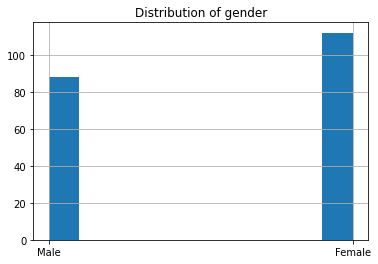

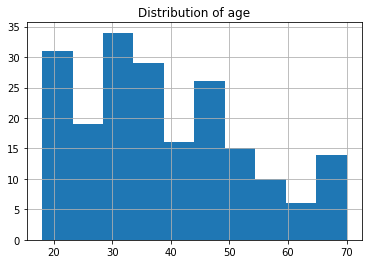

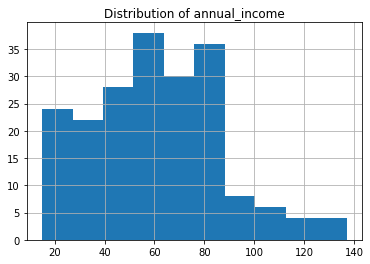

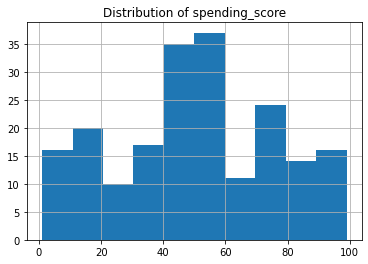

In [21]:
for col in df.columns[:-1]:
    df[col].hist()
    plt.title(f'Distribution of {col}')
    plt.show()

#### Takeaways

- slight, but not string inbalance in gender
- age and annual_income is right skewed
- I may already have an idea of how our customers are segmented
- based on the spending score distribution which is normal-ish, but seems to have several "lumps" or modes

Note: I care about distributions for the stats test

### Q2. Does the spending score differ across gender?

In [22]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
customer_id,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557
24,Male,31,25,73,1,0.250000,0.081967
40,Female,20,37,75,0,0.038462,0.180328
38,Female,30,34,73,0,0.230769,0.155738
57,Female,51,44,50,0,0.634615,0.237705


I am now comparing variables, so I HAVE to use the train dataset.

> what type of variable is spending_score? continuous  
> what type of variable is gender? categorical

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

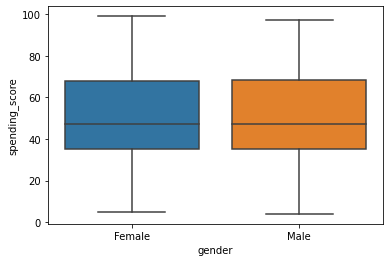

In [23]:
sns.boxplot(data=train, x='gender', y='spending_score')

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

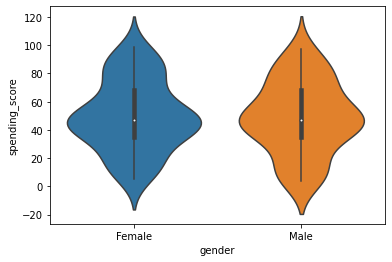

In [27]:
sns.violinplot(data=train, x='gender', y='spending_score')

<AxesSubplot:xlabel='gender', ylabel='spending_score'>

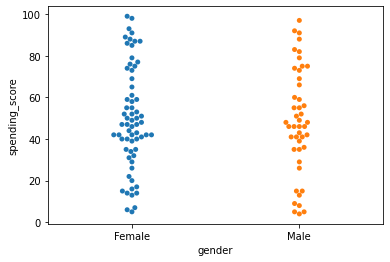

In [25]:
sns.swarmplot(data=train, x='gender', y='spending_score')

In [26]:
train.describe()

,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,40.098214,58.794643,49.473214,0.410714,0.424966,0.358972
std,14.112776,26.865745,24.865751,0.494175,0.271400,0.220211
min,18.000000,15.000000,4.000000,0.000000,0.000000,0.000000
25%,29.750000,39.000000,35.000000,0.000000,0.225962,0.196721
50%,38.000000,59.000000,47.000000,0.000000,0.384615,0.360656
75%,49.250000,76.250000,69.000000,1.000000,0.600962,0.502049
max,70.000000,137.000000,99.000000,1.000000,1.000000,1.000000


Thoughts

- it looks like gender does not affect our spending score

Which stats test to use? 

- we have continuous and categorical variables, so we will do a comparing means test
- since they are normally distributed, we can use a t-test
- we have 2 independent categories, therefore, we will use a 2-sample t-test
- since we are checking to see if they are the same, we will use a 2-tail t-test

Note: when using a t-test, we have to check for equal variances

Levene Test
- Ho: the variances are equal
- Ha: the variances are different

alpha = 0.05

In [28]:
stats.levene(train[train.gender=='Male'].spending_score,
             train[train.gender=='Female'].spending_score)

LeveneResult(statistic=0.016334996444000886, pvalue=0.8985339363273774)

In [29]:
# p is greater than our alpha, we fail to reject the null,
# suggesting we have roughly equal variance and can run a standard t-test

2-sample, 2-tail t-test

In [30]:
stats.ttest_ind(train[train.gender=='Male'].spending_score,
             train[train.gender=='Female'].spending_score)

Ttest_indResult(statistic=-0.2520372896728062, pvalue=0.8014825487089098)

> We fail to reject the null hypothesis, with a p-value greater than our alpha of 0.05

#### Takeaway

- there is not a significant difference in spending score means between gender

### Q3. Is there a relationship between spending score and annual income?

> what type of variable is spending score? continuous, target   
> what type of variable is annual income? continuous

<AxesSubplot:xlabel='annual_income', ylabel='age'>

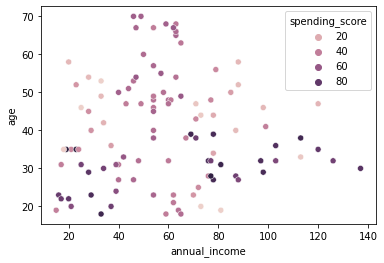

In [34]:
# age vs annual income
sns.scatterplot(data=train, x='annual_income', y='age', hue='spending_score')


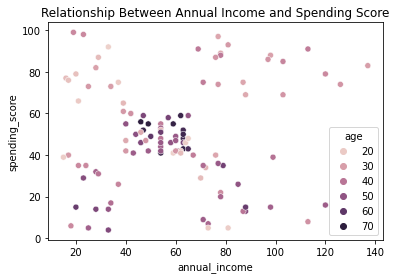

In [33]:
sns.scatterplot(data=train, x='annual_income', y='spending_score', hue='age')
plt.title('Relationship Between Annual Income and Spending Score')
plt.show()

Thoughts

- there does not appear to be a linear relationship
- it looks like a big X
- these could be clusters!

Which stats test to use? 


- we have two continuous variables, therefore, we will do a correlation test 
- since they are not normally distributed, we will use spearmans test

Spearmean R


- Ho: there is no linear correlation between annual income and spending score
- Ha: there is linear correlation between annual income and spending score

In [35]:
stats.spearmanr(train.annual_income, train.spending_score)

SpearmanrResult(correlation=0.0139166413882597, pvalue=0.8842097894086705)

#### Takeaways

- there is no linear correlation between annual income and spending score
- however, there does appear to be some kind of non-linear relationship

### Q4. Is there a relationship between age and spending score? 

<AxesSubplot:>

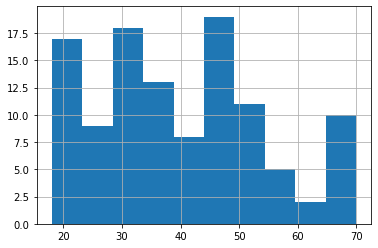

In [36]:
train.age.hist()

In [37]:
train.age.nunique()

46

In [40]:
# train.age.value_counts()

> what type of variable is age? continuous     
> what type of variable is spending score? continuous 

<AxesSubplot:xlabel='age', ylabel='spending_score'>

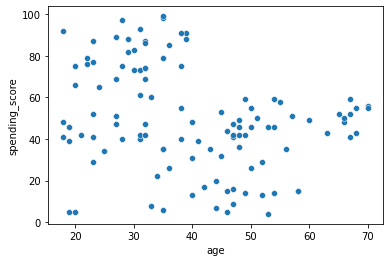

In [42]:
sns.scatterplot(data=train, x='age', y='spending_score')

Thoughts
- there doesnt really look like a linear relationship
- at 40 years old, something is happening, there is a dropoff in spending score

We'll use `pd.cut()` to make bins

In [44]:
#make new age_bin column
#adding a label is helpful for calling that column!
train['age_bins'] = pd.cut(train.age,[0,40,80], labels=['40_and_under', 'over_40'])

In [45]:
train['age_bins']

customer_id
27          over_40
24     40_and_under
40     40_and_under
38     40_and_under
57          over_40
           ...     
177         over_40
195         over_40
13          over_40
35          over_40
118         over_40
Name: age_bins, Length: 112, dtype: category
Categories (2, object): ['40_and_under' < 'over_40']

In [47]:
# train[train.age <= 40].spending_score

customer_id
24     73
40     75
38     73
163     5
78     48
       ..
26     82
182    86
18     66
59     51
1      39
Name: spending_score, Length: 62, dtype: int64

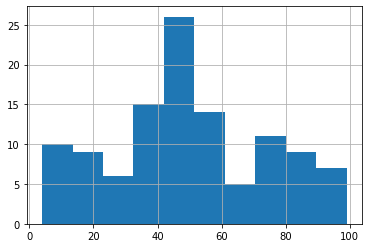

In [48]:
train.spending_score.hist()
plt.show()

<AxesSubplot:xlabel='age_bins', ylabel='spending_score'>

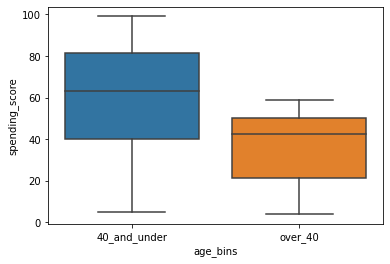

In [49]:
sns.boxplot(data=train, x='age_bins', y='spending_score')

Which stats test to use? 


- 2-sample, 2-tail, t-test

note: when using a ttest, have to test for equal variances! 

Levene test

In [50]:
#stats.levene
stats.levene(train[train.age <= 40].spending_score,
             train[train.age > 40].spending_score)

LeveneResult(statistic=15.352912166943206, pvalue=0.00015525914569012802)

> our pvalue is less than alpha, therefore we reject the null hypothesis  
> our variances are not equal

In [51]:
#stats.ttest_ind
stats.ttest_ind(train[train.age <= 40].spending_score,
             train[train.age > 40].spending_score,
               equal_var=False)

Ttest_indResult(statistic=5.292725484839427, pvalue=6.652618486151612e-07)

> We can reject our null hypothesis and there seems to be a difference in the spending scores on average amongst our populations between uneder-40s and over-40s

#### Takeaway

### Q. If we control for age, does spending score differ across annual income?

Use `sns.relplot` to control for variables

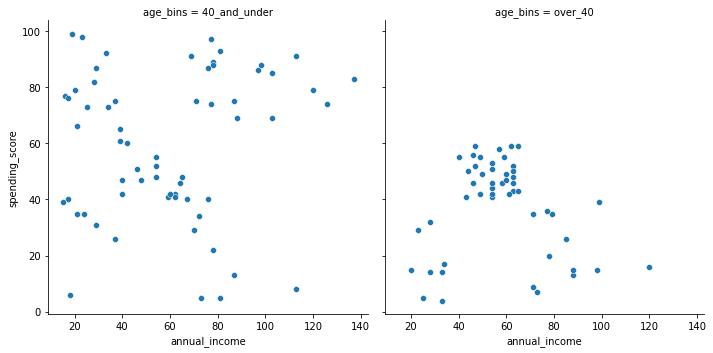

In [54]:
sns.relplot(data=train, x='annual_income',y='spending_score', col='age_bins')

Thoughts


- we see more customers with a high spending score for customers over 40
- we see half an X in the customers over 40
- customers over 40 dont have high spending scores

Thoughts

- starting to see a negative linear relationship in customers less than 30
- customers betweeen 30 and 40 are still scattered everywhere
- over 40 customers still have the half X shape

#### Does gender play a role?

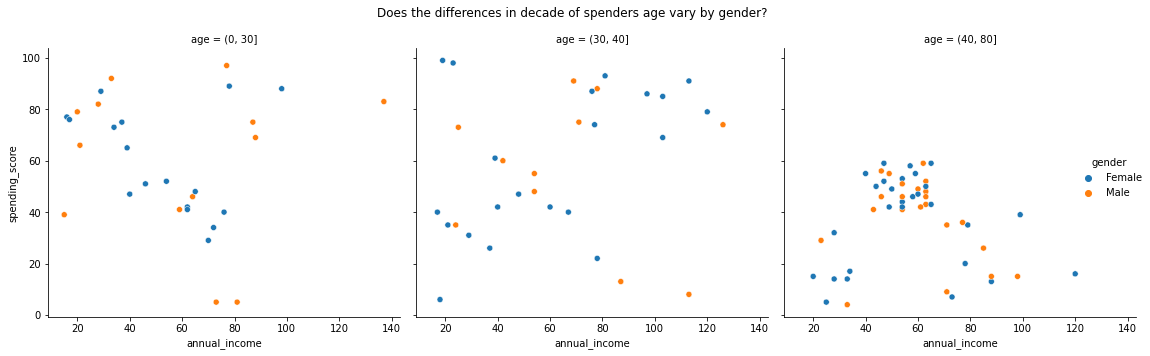

In [56]:
sns.relplot(data=train,
            x='annual_income',
            y='spending_score',
            hue='gender',
            col=pd.cut(train.age, [0,30,40,80]))
plt.suptitle('Does the differences in decade of spenders age vary by gender?')
plt.tight_layout()
plt.show()

Thoughts


- gender still doesn't tell us anything

#### Takeaways


- spending score and income does change with age, especially at the 40 year mark
- also, gender does not affect these variables

### Q. If we control for annual income, does spending score differ across age?

<AxesSubplot:>

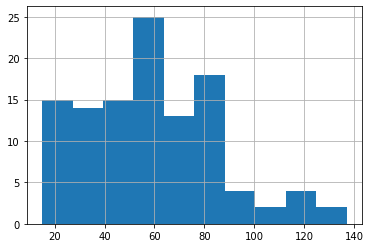

In [57]:
train.annual_income.hist()

In [59]:
train['income_bins'] = pd.cut(train.annual_income, [0,50,60,90,150])

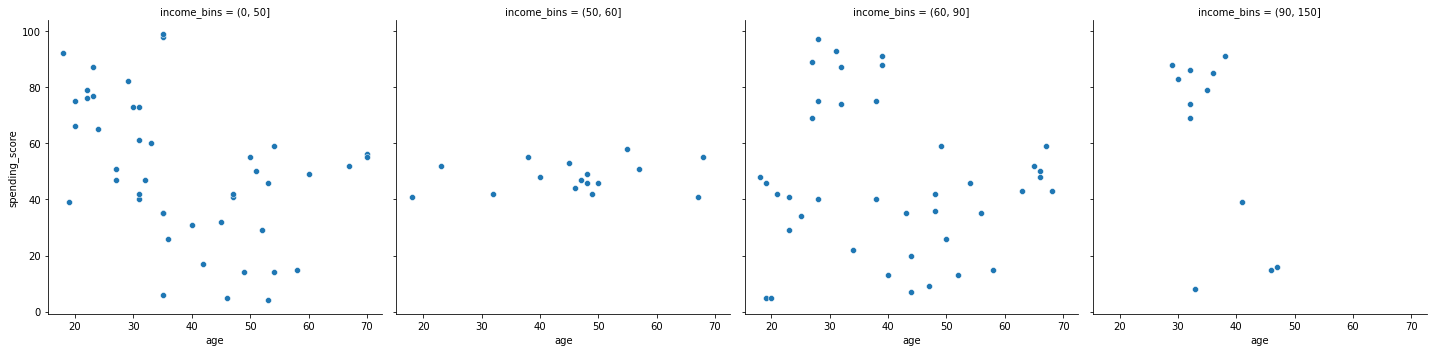

In [61]:
sns.relplot(data=train,
            x='age',
            y='spending_score',
            col='income_bins')

Takeaways


- For those in the 0-50 annual income category, I have a large spread of ages, with an overall negative appearing correlation
- 50 to 60 income bands have very stable looking spending scores in the mid-range
- 60 - 90 are very scattered
- 90+ income band have volatile spending scores, but a very specific age band

### If you don't know where to start, start with pairplot

In [62]:
train.columns

Index(['gender', 'age', 'annual_income', 'spending_score', 'is_male',
       'age_scaled', 'annual_income_scaled', 'age_bins', 'income_bins'],
      dtype='object')

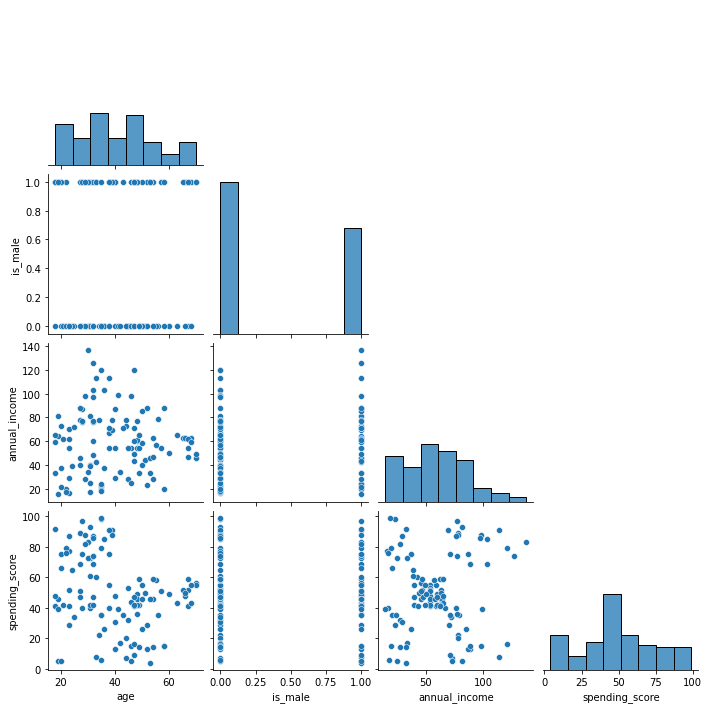

In [66]:
sns.pairplot(data=train[['age','is_male','annual_income','spending_score']],
             corner=True)

## Conclusion



Questions for further investiation:
 - There seems to be more inside of age to annual income that we haven't fully captured, but can examine basic ideas of through binning
 - Gender has not proven exceptionally useful
 - If we are making clusters *using* spending score and not *for* spending score, then annual income x spending_score seems to have 5 distinct groups
 - if we are making clusters *for targeting* spending score, then we may want to rely on a univariate cluster on age and proceed forward with further segmentation